In [1]:
import re
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np

from pathlib import Path
from pprint import pprint

from collections import Counter
from collections import defaultdict

from sklearn import preprocessing

# from jupyter_client import kernelspec
# spec = kernelspec.get_kernel_spec(kernel_name="PyTorch-2.0.1")
# print(spec.resource_dir)


In [2]:
def get_run_files(root="/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs", model='vit_l_16'):
    # return [x for x in Path(root).glob("**/*.0") if x.suffix == ".0"]
    return [x for x in Path(root).glob("**/version_0/*.0") if x.suffix == ".0" and model in str(x)]

def get_scalar_run_tensorboard(tag, filepath:str):
    values,steps = [],[]
    for e in tf.compat.v1.train.summary_iterator(filepath):
        if len(e.summary.value)>0: #Skip first empty element
            if e.summary.value[0].tag==tag:
                tensor = e.summary.value[0]
                value, step = (e.summary.value[0].simple_value, e.step)
                values.append(value)
                steps.append(step)
    return values, steps

def return_the_substring(text, keylist):
    for key in keylist:
        if key in text:
            return key
    return None

def round_it(listofvalues, by=5):
    """Rounds each value in the list of values to the closest by."""
    return map(lambda x: x-x%by, listofvalues)

lr_pattern = re.compile(r'lr([0-9]*\.?[0-9]+)--')
def get_learningrates(files):
    """Extract the learning rate from the file name.
    
        ex: "...vit_l_16--lr0.00025--bs128...:
    """
    for file in files:
        match = lr_pattern.search(str(file))
        if match:
            yield match.group(1)

    
list_of_tags = [ 'train_acc_epoch',
 'train_f1_epoch',
 'train_prec_epoch',
 'train_rec_epoch',
 'val_acc_epoch',
 'val_f1_epoch',
 'val_prec_epoch',
 'val_rec_epoch']

# list_of_tags = ["train_f1_epoch"]

In [3]:
# f = '/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs/2023-09-22--vit_l_16--lr0.01--bs128--transformsRandomHorizontalFlip_RandomVerticalFlip/version_0/events.out.tfevents.1695365914.c0800a-s23.ufhpc.1607097.0'
# set([ e.summary.value[0].tag for e in tf.compat.v1.train.summary_iterator(f) if e.summary.value ])

In [4]:
files = get_run_files()
# list(set(filter(lr_pattern.search, map(str, files))))
# list(map(lambda x: x.absolute, files))
# str(files[0].absolute())
set(get_learningrates(files))

{'0.0001', '0.00025', '0.0005', '0.001', '0.01', '0.1'}

In [5]:
def generate_plot(model='vit_l_16'):
    files = get_run_files(model=model)
    print(f"total files: {len(files)}")
    
    lrs = list(get_learningrates(files)) # learning rates of each file
    print(f"total lrs: {len(lrs)}")

    tags = list_of_tags
    print(f"{tags=}")
    
    # Grab tags from the tensorboard log files
    for tag in tags:
        lr = {}
        for rate in lrs:
            lr[rate] = { "steps": [], "values": [] }
                
        # print(f"total all: {len( list(zip(map(str,files), lrs)) )}")
        for file in map(str,files):
            values, steps = get_scalar_run_tensorboard(tag, file)
            steps = round_it(steps, 50)
            
            # Extract the file learning rage
            filelr = str(list(get_learningrates([file]))[0])

            lr[filelr]["steps"].extend(steps)
            lr[filelr]["values"].extend(values)
        
        # Get mean and stddev for each step in lr2
        lr2 = {}
        for i, (k,data) in enumerate(lr.items()):
            d = defaultdict(list) # values list
            for (step, value) in zip(data["steps"], data["values"]):
                d[step].append(value)
            # Get avg and stddev of each step
            d2 = {}
            for (step, vals) in d.items():
                d2[step] = {"avg": np.average(vals), "std": np.std(vals) }
            lr2[k] = d2
        
        import pprint 
        # pprint.pprint(lr2)
        
        plt.figure()
        
        linestyle = ['solid', 'dotted', 'dashed', 'dashdot', (0, (1, 10)), (0, (5, 10))]

        handlekeys = [] # Used for legend
        for linestyle, (key, data) in zip(linestyle, lr2.items()):
            # e.g. key = "0.01", data = {step: { avg, std } }
            # print(f"key: {key}") 

            datakeys = list(data.keys())
            # datakeys = preprocessing.minmax_scale([list(data.keys())], axis=1)
            normalizedsteps = preprocessing.minmax_scale([datakeys], axis=1)[0]
            
            averages = list(map(lambda x: x["avg"], list(data.values())))
            upperbound = list(map(lambda x: x["avg"] + x["std"], list(data.values())))
            lowerbound = list(map(lambda x: x["avg"] - x["std"], list(data.values())))

            # handle, = plt.plot(datakeys, averages, linewidth=1, label=key)
            handle, = plt.plot(normalizedsteps, averages, linewidth=1, label=key, linestyle=linestyle)    
        
            handlekeys.append(handle)
            # plt.fill_between(datakeys, upperbound, lowerbound, alpha=.5, linewidth=0)   
            plt.fill_between(normalizedsteps, upperbound, lowerbound, alpha=.3, linewidth=0)   

        # plt.legend(lr.keys(), loc="lower right")
        plt.ylim([0, 1.19])
        plt.grid()
        plt.legend(handles=handlekeys, loc="lower right")
        # plt.xlabel("steps")
        plt.ylabel(tag)

        #print(f'{sorted(Counter(lr["0.01"]["steps"]).items())}')


total files: 192
total lrs: 192
tags=['train_acc_epoch', 'train_f1_epoch', 'train_prec_epoch', 'train_rec_epoch', 'val_acc_epoch', 'val_f1_epoch', 'val_prec_epoch', 'val_rec_epoch']
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


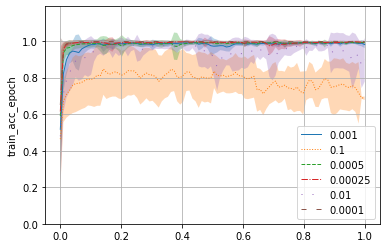

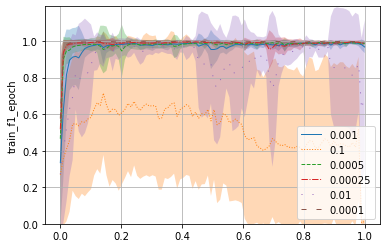

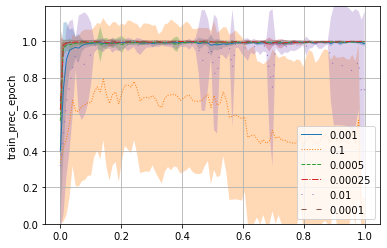

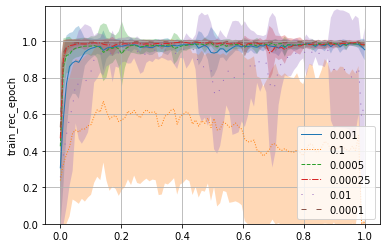

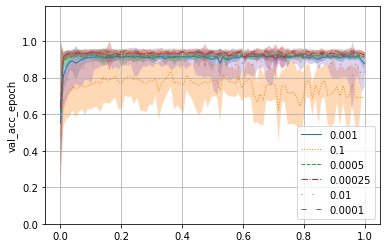

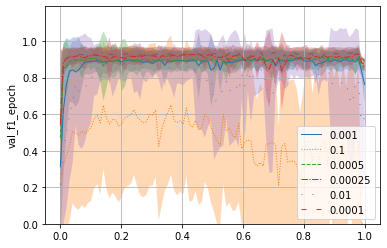

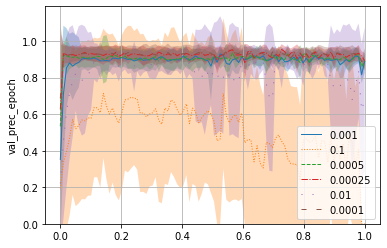

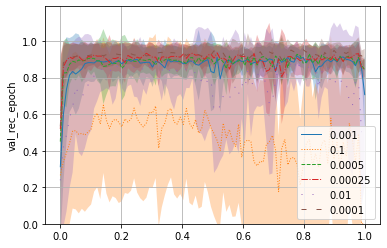

In [6]:
# NotebookApp.iopub_data_rate_limit=10000000.0
generate_plot()

total files: 192
total lrs: 192
tags=['train_acc_epoch', 'train_f1_epoch', 'train_prec_epoch', 'train_rec_epoch', 'val_acc_epoch', 'val_f1_epoch', 'val_prec_epoch', 'val_rec_epoch']


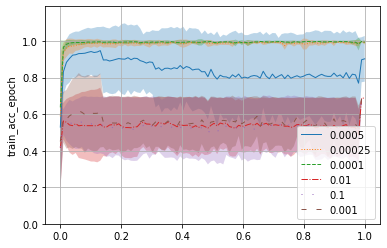

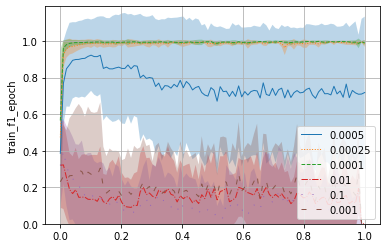

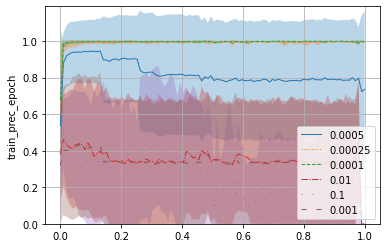

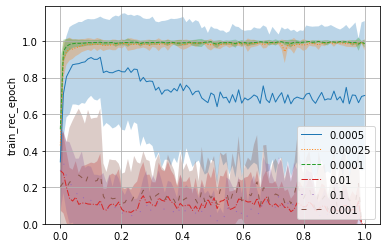

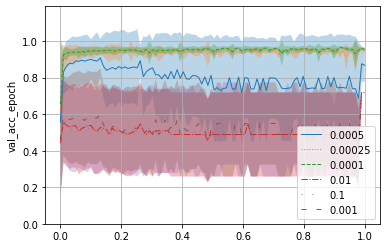

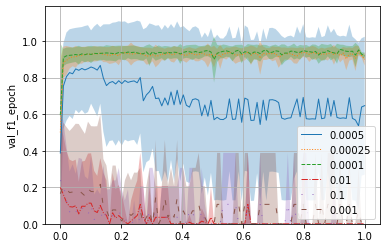

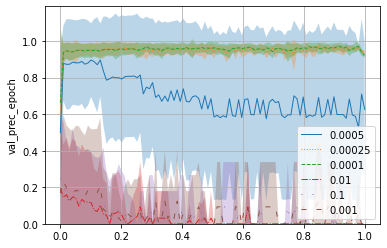

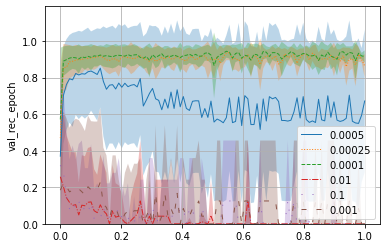

In [7]:
generate_plot(model="vgg")

In [8]:
# List all the files
get_run_files()

[PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs/2023-09-25--vit_l_16--lr0.001--bs64--transformsNone--categorygender/version_0/events.out.tfevents.1695675242.c0800a-s23.ufhpc.3592131.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs/2023-09-26--vit_l_16--lr0.1--bs32--transformsRandomErasing_RandomHorizontalFlip_RandomVerticalFlip--categorypose/version_0/events.out.tfevents.1695747320.c0801a-s17.ufhpc.646174.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs/2023-09-25--vit_l_16--lr0.0005--bs16--transformsRandomErasing--categorygender/version_0/events.out.tfevents.1695674215.c0801a-s11.ufhpc.1872345.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs/2023-09-25--vit_l_16--lr0.001--bs128--transformsRandomErasing_RandomHorizontalFlip_RandomVerticalFlip--categorygender/version_0/events.out.tfevents.1695675078.c0801a-s35.ufhpc.3632197.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/out/